Retrieves images from "full_imgs" and stores each VOI separately in "train_imgs". Retrieves spreadsheet listing VOIs and stores them in text file. Requires data-retrieval to be run first.

In [31]:
import config
import helper_fxns as hf
import transforms as tr
import importlib
import numpy as np
import os
import requests
import sys
import copy
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

with open("train_list.txt", "r") as f:
    vois = [x.split(',') for x in f.read().split("\n")]

voi_df = pd.DataFrame(vois, columns = ["Filename", "x1", "x2", "y1", "y2", "z1", "z2", "cls"]).dropna()
voi_df = voi_df.astype({"x1": int, "x2": int, "y1": int, "y2": int, "z1": int, "z2": int})

voi_df['dx'] = voi_df.apply(lambda row: row['x2'] - row['x1'], axis=1)
voi_df['dy'] = voi_df.apply(lambda row: row['y2'] - row['y1'], axis=1)
voi_df['dz'] = voi_df.apply(lambda row: row['z2'] - row['z1'], axis=1)

In [32]:
importlib.reload(config)
importlib.reload(hf)

<module 'helper_fxns' from 'C:\\Users\\Clinton\\Documents\\voi-classifier\\helper_fxns.py'>

In [33]:
C = config.Config()
final_size = C.dims

voi_df_art = pd.read_csv(C.art_voi_path)
voi_df_ven = pd.read_csv(C.ven_voi_path)

In [18]:
#voi_df = voi_df[~voi_df['cls'].isin(['colorectal', 'adenoma', 'fnh'])]
#set(voi_df['cls'].values)

In [12]:
def regenerate_dataset(acc_nums):
    for acc_num in acc_nums:
        for cls in os.listdir(C.aug_dir):
            fn_stem = C.aug_dir + classes[i] + "\\" + acc_num
            fn_stem = C.orig_dir + classes[i] + "\\" + acc_num
            os.remove( + "_" + str(voi_num) + "_" + str(i), cropped_imgs[i])
            #os.remove()

In [34]:
def extract_voi(img, voi, final_size, aug=False, ven_voi=None):
    """Input: image, a voi from the image (as pd.Series), target size in voxels, and whether to augment.
    Outputs list of images (np.ndarray) and list of classes (string).
    Assumes that there is no voi so close to the edge that getting a volume of size final_size would make it go out of bounds.
    """
    
    voi_imgs = []
    classes = []
    temp_img = copy.deepcopy(img)
    
    # if augmenting, take a larger volume from the original image so rotating it will not cut off any part
    if aug:
        crop_size = [math.ceil(x*math.sqrt(2)) for x in final_size]
    else:
        crop_size = final_size
        
    if ven_voi is not None:
        temp_img = hf.align(temp_img, voi, ven_voi)
    
    exceed_ratio = max(voi['dx']/crop_size[0], voi['dy']/crop_size[1], voi['dz']/crop_size[2]) / 1

    # downscale image until it fits in final_size and cannot be cut off by rotation
    if exceed_ratio > 1:# or exceed_ratio < 0.4:
        #if exceed_ratio < 0.4:
        #    exceed_ratio += 0.2
            
        temp_img = tr.scale3d(temp_img, [1/exceed_ratio]*3)
        x1 = round(voi['x1'] / exceed_ratio)
        x2 = round(voi['x2'] / exceed_ratio)
        y1 = round(voi['y1'] / exceed_ratio)
        y2 = round(voi['y2'] / exceed_ratio)
        z1 = round(voi['z1'] / exceed_ratio)
        z2 = round(voi['z2'] / exceed_ratio)
    else:
        x1 = voi['x1']
        x2 = voi['x2']
        y1 = voi['y1']
        y2 = voi['y2']
        z1 = voi['z1']
        z2 = voi['z2']

    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
        
    xpad = max(crop_size[0] - dx,0)
    ypad = max(crop_size[1] - dy,0)
    zpad = max(crop_size[2] - dz,0)

    side_padding = math.ceil(max(xpad, ypad, zpad) / 2)

    pad_img = []

    for ch in range(temp_img.shape[-1]):
        pad_img.append(np.pad(temp_img[:,:,:,ch], side_padding, 'constant'))

    pad_img = np.stack(pad_img, axis=3)

    x1 += side_padding - math.ceil(xpad/2)
    x2 += side_padding + math.floor(xpad/2)
    y1 += side_padding - math.ceil(ypad/2)
    y2 += side_padding + math.floor(ypad/2)
    z1 += side_padding - math.ceil(zpad/2)
    z2 += side_padding + math.floor(zpad/2)

    pad_img = pad_img[x1:x2, y1:y2, z1:z2, :]
        
    if aug:
        aug_imgs = hf.augment(pad_img, final_size, translate=[1,1,0], exceed_ratio=exceed_ratio, num_samples = C.aug_factor[voi['cls']])
        voi_imgs = voi_imgs + aug_imgs
        classes = classes + [voi['cls']] * len(aug_imgs)

    else:
        voi_imgs = [pad_img]
        #if voi_imgs[0].shape[0] != final_size[0] or voi_imgs[0].shape[1] != final_size[1] or voi_imgs[0].shape[2] != final_size[2]:
        #    print(voi)
        #    print(x1,x2,y1,y2,z1,z2)
        #    print(voi_imgs[0].shape, final_size, zpad)
        #    raise ValueError("zzz")
        
        classes = [voi['cls']]
        
    return voi_imgs, classes

In [35]:
aug=True
t = time.time()
classes_to_include = ['cyst', 'hcc', 'hemangioma', 'colorectal', 'fnh', 'cholangio']

voi_df_ven["id"] = str(voi_df_ven["id"])

if os.path.exists(C.aug_dir):
    print("Warning: path", C.aug_dir, "already exists.")
else:
    os.makedirs(C.aug_dir)
if not os.path.exists(C.orig_dir):
    os.makedirs(C.orig_dir)
    
for cls in classes_to_include:
    if not os.path.exists(C.orig_dir + cls):
        os.makedirs(C.orig_dir + cls)
    if not os.path.exists(C.aug_dir + cls):
        os.makedirs(C.aug_dir + cls)
    
# iterate over image series
for img_fn in os.listdir(C.full_img_dir):
    img = np.load(C.full_img_dir+"\\"+img_fn)
    art_vois = voi_df_art[(voi_df_art["Filename"] == img_fn) & (voi_df_art["cls"].isin(classes_to_include))]
    
    # iterate over each voi in that image
    for voi_num, voi in enumerate(art_vois.iterrows()):
        ven_voi = voi_df_ven[voi_df_ven["id"] == voi[1]["id"]]
        
        if len(ven_voi) == 0: #venous voi was not specified separately
            cropped_imgs, classes = extract_voi(img, copy.deepcopy(voi[1]), final_size, aug=aug)
        else:
            cropped_imgs, classes = extract_voi(img, copy.deepcopy(voi[1]), final_size, aug=aug, ven_voi=ven_voi.iloc[0])

        for i in range(len(cropped_imgs)):
            np.save(C.aug_dir + classes[i] + "\\" + img_fn[:-4] + "_" + str(voi_num) + "_" + str(i), cropped_imgs[i])

        # save unaugmented vois as well
        if aug:
            if len(ven_voi) == 0: #venous voi was not specified separately
                cropped_imgs, classes = extract_voi(img, copy.deepcopy(voi[1]), final_size, aug=False)
            else:
                cropped_imgs, classes = extract_voi(img, copy.deepcopy(voi[1]), final_size, aug=False, ven_voi=ven_voi.iloc[0])

            np.save(C.orig_dir+classes[0]+"\\"+img_fn[:-4]+"_" + str(voi_num), cropped_imgs[0])
                
        if voi_num % 20 == 0:
            print(".", end="")
print("")
print(time.time()-t)

............................................................................................................

error: C:\bld\opencv_1498165712905\work\opencv-3.2.0\modules\imgproc\src\imgwarp.cpp:5977: error: (-215) src.cols > 0 && src.rows > 0 in function cv::warpAffine


for x in os.listdir("train_imgs\\hcc\\"):
    if x[-6] != "_" and int(x[-6:-4]) > 30:
        os.remove("train_imgs\\hcc\\" + x)

[x for x in os.listdir("train_imgs\\hcc\\") if x[-6] != "_" and int(x[-6:-4]) > 30]

os.listdir("train_imgs\\hcc")[3]

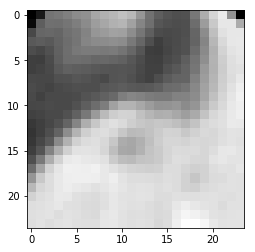

In [27]:
img = np.load("orig_imgs\\cyst\\E100529980_1.npy")
plt.imshow(img[:,:,5,0], cmap='gray')

In [ ]:
img_fn = "E100529980.npy"
img = np.load("full_imgs\\"+img_fn)
hf.plot_section(img, voi_df[voi_df["Filename"] == img_fn].iloc[0], pad=0)